In [224]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

In [226]:
train_df = pd.read_csv("./train_1.csv")
test_df = pd.read_csv("./test_1.csv")
aux_df = pd.read_csv("./auxiliary-data/sg-shopping-malls.csv")

In [227]:
aux_df.head()

,name,lat,lng,wikipedia_link
0,100 AM,1.275012,103.841372,NaN
1,313@Somerset,1.301013,103.838540,NaN
2,Aperia,1.309714,103.863837,NaN
3,Balestier Hill Shopping Centre,1.325442,103.842521,NaN
4,Bugis Cube,1.298276,103.855555,NaN


## Check for NULL values

In [228]:
aux_df.isnull().any()

name              False
lat               False
lng               False
wikipedia_link     True
dtype: bool

In [229]:
aux_df['wikipedia_link'].unique()

array([nan, '/wiki/Bugis_Junction', '/wiki/Bugis%2B',
       '/wiki/Capitol_Piazza', '/wiki/Cathay_Cineleisure_Orchard',
       '/wiki/The_CentrePoint', '/wiki/City_Square_Mall',
       '/wiki/CityLink_Mall', '/wiki/DUO', '/wiki/Far_East_Plaza',
       '/wiki/Funan,_Singapore', '/wiki/Great_World_City',
       '/wiki/HDB_Hub', '/wiki/Holland_Village,_Singapore',
       '/wiki/ION_Orchard', '/wiki/Junction_8', '/wiki/Liang_Court',
       '/wiki/Liat_Towers', '/wiki/Lucky_Plaza', '/wiki/Marina_Bay_Sands',
       '/wiki/Marina_Bay_Link_Mall', '/wiki/Marina_One',
       '/wiki/Marina_Square', '/wiki/Millenia_Walk',
       '/wiki/Mustafa_Centre', '/wiki/Ngee_Ann_City',
       '/wiki/Orchard_Central', '/wiki/Orchard_Gateway',
       '/wiki/Palais_Renaissance', '/wiki/People%27s_Park_Centre',
       '/wiki/People%27s_Park_Complex', '/wiki/Plaza_Singapura',
       '/wiki/Raffles_City_Singapore', '/wiki/Shaw_House_and_Centre',
       '/wiki/Sim_Lim_Square', '/wiki/South_Beach,_Singapore',
     

There are some null values in wikipedia_link column. We do not need the wikipedia link column for any analysis so we will drop this column and take care of the NULL values also.

In [230]:
aux_df = aux_df.drop(columns=['wikipedia_link'])

In [231]:
aux_df.isnull().any()

name    False
lat     False
lng     False
dtype: bool

### Checking for duplicate values

In [232]:
aux_df.duplicated().any()

False

### Club latitude and longitude together and drop 'lat' and 'lng' columns

In [233]:
aux_df['lat_long'] = list(zip(aux_df.lat, aux_df.lng))

In [234]:
aux_df = aux_df.drop(columns=['lat','lng'])

In [235]:
aux_df.head()

,name,lat_long
0,100 AM,"(1.2750117, 103.8413716)"
1,313@Somerset,"(1.3010128, 103.83853994515806)"
2,Aperia,"(1.3097138000000002, 103.8638367)"
3,Balestier Hill Shopping Centre,"(1.32544235, 103.84252114874478)"
4,Bugis Cube,"(1.2982756000000002, 103.8555546)"


# ADD SOME PLOTS HERE

### Extract lat_long and year columns from train and test data sets

In [236]:
train_df_temp = train_df[["lat_long"]]
test_df_temp = test_df[["lat_long"]]

### Drop duplicate locations

In [237]:
train_df_temp = train_df_temp.drop_duplicates(subset=['lat_long'])
test_df_temp = test_df_temp.drop_duplicates(subset=['lat_long'])

### Add columns to store the nearest shopping mall and its distance and number of shopping malls within 0.5km

In [238]:
train_df_temp["nearest_shopping_mall"] = str("--")
train_df_temp["nearest_shopping_mall_distance"] = math.inf
train_df_temp["shopping_mall_half_km"] = 0
test_df_temp["nearest_shopping_mall"] = str("--")
test_df_temp["nearest_shopping_mall_distance"] = math.inf
test_df_temp["shopping_mall_half_km"] = 0
train_df_temp = train_df_temp.reset_index()
test_df_temp = test_df_temp.reset_index()

In [239]:
aux_df = aux_df.reset_index()

In [240]:
aux_df.head()

,index,name,lat_long
0,0,100 AM,"(1.2750117, 103.8413716)"
1,1,313@Somerset,"(1.3010128, 103.83853994515806)"
2,2,Aperia,"(1.3097138000000002, 103.8638367)"
3,3,Balestier Hill Shopping Centre,"(1.32544235, 103.84252114874478)"
4,4,Bugis Cube,"(1.2982756000000002, 103.8555546)"


In [241]:
train_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3690080642700195, 103.95869445800781)",--,inf,0
1,1,"(1.3990070819854736, 103.90699005126953)",--,inf,0
2,2,"(1.3883482217788696, 103.87381744384766)",--,inf,0
3,3,"(1.3184930086135864, 103.7667007446289)",--,inf,0
4,4,"(1.3481495380401611, 103.74266052246094)",--,inf,0


In [242]:
test_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3465807437896729, 103.74408721923828)",--,inf,0
1,1,"(1.3576176166534424, 103.96138000488281)",--,inf,0
2,2,"(1.337803840637207, 103.74199676513672)",--,inf,0
3,3,"(1.380083680152893, 103.84957122802734)",--,inf,0
4,4,"(1.3139597177505493, 103.76982879638672)",--,inf,0


Converting our dataframe to numpy arrays for faster computation

In [243]:
train_df_temp_numpy = train_df_temp.to_numpy()
test_df_temp_numpy = test_df_temp.to_numpy()
aux_df_numpy = aux_df.to_numpy()

In [244]:
print("Shape of train_df_temp_numpy :",np.shape(train_df_temp_numpy))
print("Shape of test_df_temp_numpy :",np.shape(test_df_temp_numpy))
print("Shape of aux_df_numpy :",np.shape(aux_df_numpy))

Shape of train_df_temp_numpy : (9138, 5)
Shape of test_df_temp_numpy : (8990, 5)
Shape of aux_df_numpy : (174, 3)


## Get the nearest shopping mall and its distance from HDB. Also count the number of shopping mall within 0.5km from HDB

In [245]:
print("Get distance for each location and update nearest shopping mall and its distance")
for i in range(len(train_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = train_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 1:
            count+=1
    train_df_temp_numpy[i][2] = min_dist_mrt
    train_df_temp_numpy[i][3] = min_dist
    train_df_temp_numpy[i][4] = count

print("Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe")
for i in range(len(train_df_temp_numpy)):
    dataframe_index = train_df_temp_numpy[i][0]
    train_df_temp.loc[i, "nearest_shopping_mall"] = train_df_temp_numpy[i][2]
    train_df_temp.loc[i, "nearest_shopping_mall_distance"] = train_df_temp_numpy[i][3]
    train_df_temp.loc[i, "shopping_mall_half_km"] = train_df_temp_numpy[i][4]

Get distance for each location and update nearest shopping mall and its distance
Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe


In [246]:
print("Get distance for each location and update nearest shopping mall and its distance")
for i in range(len(test_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = test_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 0.5:
            count+=1
    test_df_temp_numpy[i][2] = min_dist_mrt
    test_df_temp_numpy[i][3] = min_dist
    test_df_temp_numpy[i][4] = count

print("Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe")
for i in range(len(test_df_temp_numpy)):
    dataframe_index = test_df_temp_numpy[i][0]
    test_df_temp.loc[i, "nearest_shopping_mall"] = test_df_temp_numpy[i][2]
    test_df_temp.loc[i, "nearest_shopping_mall_distance"] = test_df_temp_numpy[i][3]
    test_df_temp.loc[i, "shopping_mall_half_km"] = test_df_temp_numpy[i][4]

Get distance for each location and update nearest shopping mall and its distance
Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe


In [247]:
train_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3690080642700195, 103.95869445800781)",Downtown East,1.033117,0
1,1,"(1.3990070819854736, 103.90699005126953)",Rivervale Mall,0.806018,4
2,2,"(1.3883482217788696, 103.87381744384766)",The Seletar Mall,0.452401,2
3,3,"(1.3184930086135864, 103.7667007446289)",321 Clementi,0.456448,3
4,4,"(1.3481495380401611, 103.74266052246094)",West Mall,0.763916,1


In [248]:
test_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3465807437896729, 103.74408721923828)",West Mall,0.693774,0
1,1,"(1.3576176166534424, 103.96138000488281)",Tampines Mall,1.934091,0
2,2,"(1.337803840637207, 103.74199676513672)",Jem,0.524649,0
3,3,"(1.380083680152893, 103.84957122802734)",Djitsun Mall,0.829051,0
4,4,"(1.3139597177505493, 103.76982879638672)",321 Clementi,0.604384,0


### We will now merge the result with our original data frames

In [249]:
temp = train_df_temp[["lat_long", "nearest_shopping_mall", "nearest_shopping_mall_distance","shopping_mall_half_km"]]
train_df = pd.merge(train_df, temp, on="lat_long", how='left')

temp = test_df_temp[["lat_long", "nearest_shopping_mall", "nearest_shopping_mall_distance","shopping_mall_half_km"]]
test_df = pd.merge(test_df, temp, on="lat_long", how='left')

### Nearest MRT and its distance from HDB has been added to our dataframe

In [250]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,pasir ris drive,pasir ris,east region,209700.0,8,2001,2.0,"(1.3690080642700195, 103.95869445800781)",Downtown East,1.033117,0
1,punggol,5-room,196B,punggol field,110.0,improved,2003,punggol field,punggol,north-east region,402300.0,10,2014,11.0,"(1.3990070819854736, 103.90699005126953)",Rivervale Mall,0.806018,4
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,fernvale,sengkang,north-east region,351000.0,9,2020,2.0,"(1.3883482217788696, 103.87381744384766)",The Seletar Mall,0.452401,2
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,clementi north,clementi,west region,151200.0,10,2000,8.0,"(1.3184930086135864, 103.7667007446289)",321 Clementi,0.456448,3
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,bukit batok west,bukit batok,west region,318600.0,1,2013,8.0,"(1.3481495380401611, 103.74266052246094)",West Mall,0.763916,1


In [251]:
test_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,month_no,year,storey,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,bukit batok,4-room,186,bukit batok west avenue 6,94.0,new generation,1989,bukit batok west,bukit batok,west region,1,2004,5.0,"(1.3465807437896729, 103.74408721923828)",West Mall,0.693774,0
1,tampines,5-room,366,tampines street 34,122.0,improved,1997,tampines east,tampines,east region,11,2001,5.0,"(1.3576176166534424, 103.96138000488281)",Tampines Mall,1.934091,0
2,jurong east,3-room,206,jurong east street 21,67.0,new generation,1982,toh guan,jurong east,west region,7,2002,2.0,"(1.337803840637207, 103.74199676513672)",Jem,0.524649,0
3,ang mo kio,3-room,180,Ang Mo Kio Avenue 5,82.0,new generation,1981,yio chu kang east,ang mo kio,north-east region,4,2015,5.0,"(1.380083680152893, 103.84957122802734)",Djitsun Mall,0.829051,0
4,clementi,5-room,356,clementi avenue 2,117.0,standard,1978,clementi north,clementi,west region,4,2004,2.0,"(1.3139597177505493, 103.76982879638672)",321 Clementi,0.604384,0


# ADD SOME PLOTS HERE

<AxesSubplot:>

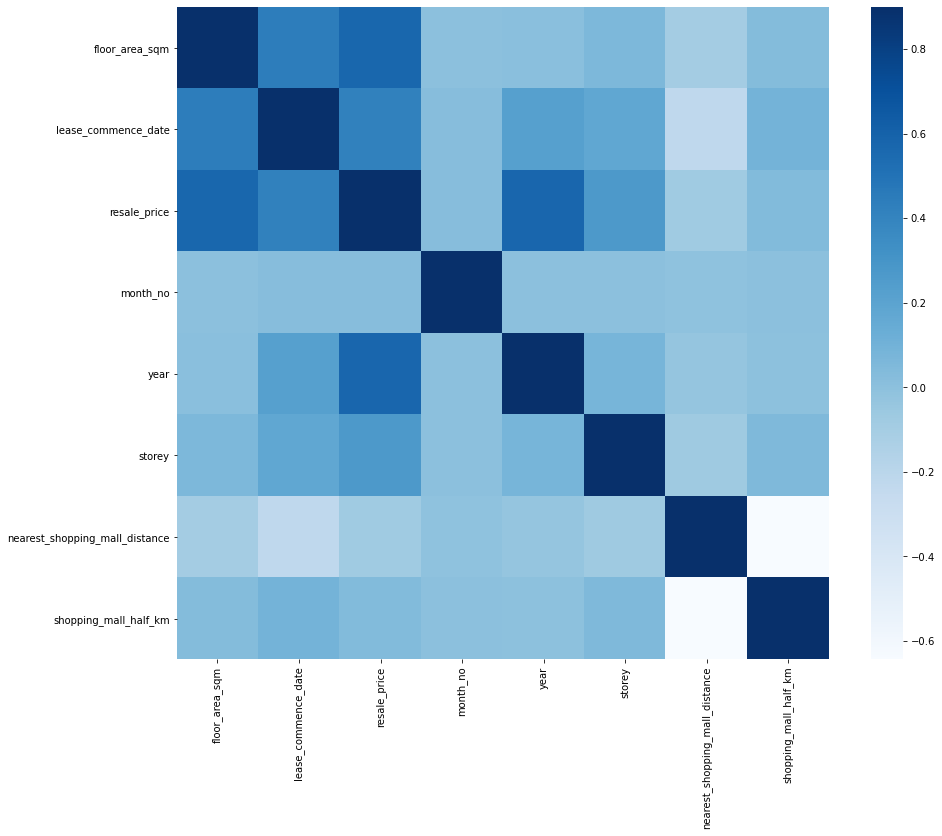

In [252]:
corr = train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [253]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,resale_price
resale_price,1.000000
year,0.578717
floor_area_sqm,0.570385
lease_commence_date,0.423578
storey,0.269431
shopping_mall_half_km,0.039269
month_no,0.025448
nearest_shopping_mall_distance,-0.074991


### Reduce the size of dataframe to save memory during training

In [254]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 62.583221435546875  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  44.055294036865234  MB
This is  70.39473684210526 % of the initial size
Memory usage of properties dataframe is : 14.822479248046875  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  10.602190017700195  MB
This is  71.52777777777777 % of the initial size


### Segregate the columns

In [255]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
    "nearest_shopping_mall_distance",
    "shopping_mall_half_km"
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    "nearest_shopping_mall"
]

### Drop the selected columns

In [256]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

In [257]:
train_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,resale_price,month_no,year,storey,nearest_shopping_mall_distance,shopping_mall_half_km
0,pasir ris,4-room,118.0,model a,1989,pasir ris drive,pasir ris,east region,209700.0,8,2001,2,1.033117,0
1,punggol,5-room,110.0,improved,2003,punggol field,punggol,north-east region,402300.0,10,2014,11,0.806018,4
2,sengkang,5-room,112.0,premium apartment,2004,fernvale,sengkang,north-east region,351000.0,9,2020,2,0.452401,2
3,clementi,3-room,67.0,new generation,1980,clementi north,clementi,west region,151200.0,10,2000,8,0.456448,3
4,bukit batok,3-room,73.0,model a,1985,bukit batok west,bukit batok,west region,318600.0,1,2013,8,0.763916,1


In [258]:
test_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,month_no,year,storey,nearest_shopping_mall_distance,shopping_mall_half_km
0,bukit batok,4-room,94.0,new generation,1989,bukit batok west,bukit batok,west region,1,2004,5,0.693774,0
1,tampines,5-room,122.0,improved,1997,tampines east,tampines,east region,11,2001,5,1.934091,0
2,jurong east,3-room,67.0,new generation,1982,toh guan,jurong east,west region,7,2002,2,0.524648,0
3,ang mo kio,3-room,82.0,new generation,1981,yio chu kang east,ang mo kio,north-east region,4,2015,5,0.829051,0
4,clementi,5-room,117.0,standard,1978,clementi north,clementi,west region,4,2004,2,0.604384,0


### One hot encode categorical columns

In [259]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [260]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [261]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

## Decision Tree

In [276]:
dt_1 = tree.DecisionTreeRegressor()

In [277]:
%%time
dt_1 = dt_1.fit(train_x, train_y)

Wall time: 11.3 s


In [278]:
train_prediction = dt_1.predict(train_x)
val_prediction = dt_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 1488.9350825464644
Validation error(RMSE) : 25452.89769584025
R2 score for training data : 0.9998687655536989
R2 score for validation data : 0.9613205903599434


In [279]:
dt_2 = tree.DecisionTreeRegressor(max_depth=30,min_samples_split=30)

In [280]:
%%time
dt_2 = dt_2.fit(train_x, train_y)

Wall time: 9.87 s


In [281]:
train_prediction = dt_2.predict(train_x)
val_prediction = dt_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 17349.20508204783
Validation error(RMSE) : 22597.906395723498
R2 score for training data : 0.9821821425999284
R2 score for validation data : 0.9695110980389879


In [262]:
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

In [263]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13923.812126658353
Validation error(RMSE) : 22736.22420840453
R2 score for training data : 0.9885234163423098
R2 score for validation data : 0.9691367213690145


## Random Forest

In [264]:
rf_1 = RandomForestRegressor()

In [265]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 12min 17s


RandomForestRegressor()

In [266]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 6998.453248929198
Validation error(RMSE) : 18350.534429751668
R2 score for training data : 0.9971006513102263
R2 score for validation data : 0.9798950588214284


## XGBOOST

In [282]:
xgb_model_1 = xgboost.XGBRegressor()

In [283]:
%%time
xgb_model_1.fit(train_x,train_y)

Wall time: 1min 1s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [284]:
train_prediction = xgb_model_1.predict(train_x)
val_prediction = xgb_model_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 20830.125
Validation error(RMSE) : 21363.264
R2 score for training data : 0.9743149693687404
R2 score for validation data : 0.9727516265075372


In [267]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [268]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 4min 39s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [269]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11824.589
Validation error(RMSE) : 22054.135
R2 score for training data : 0.9917230867987636
R2 score for validation data : 0.9709607494815772


## LightGBM

In [270]:
gbm_1 = lgb.LGBMRegressor()

In [271]:
gbm_1 = gbm_1.fit(train_x,train_y)

In [272]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 23900.198320699328
Validation error(RMSE) : 23988.143031508727
R2 score for training data : 0.9661857836776211
R2 score for validation data : 0.96564431339626


In [273]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [274]:
gbm_2 = gbm_2.fit(train_x,train_y)

In [275]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11888.668551984898
Validation error(RMSE) : 16118.68795639536
R2 score for training data : 0.9916331351074883
R2 score for validation data : 0.9844881088468336
